#STEP 1: Brief description of the problem and data

Our assignment is based on the Histopathologic Cancer Detection Kaggle Competition, which is itself based on the PatchCamelyon with duplicates removed. The task is binary image classification between "has cancer" and "does NOT have cancer."

We have thousands of small pathology images, and we trying to determine if the center of the image (32x32) contains at least one pixel of tumor tissue. Each image is 96x96 but the center image is the focus. The data X is structured like (N, 96, 96, 3) where N is the number of images and where X[0,0,0] is the first column, first row pixel of the first image. This value itself is an array representing [R,G,B] color values.

We have 57,458 test images and 184,947  training images, as well as a train_labels csv file that provides the ground truth of whether the training images contain a tumor.

The dataset includes:

*   184,947 labeled training images, each stored as a .tif file in the train folder.
*   57,458 test images in the test folder, used for generating predictions for Kaggle submission.
*   A train_labels.csv file that maps image IDs to binary labels, where 1 means tumor is present and 0 means no tumor

Each ID is a 40 digit hexadecimal and needs to be matched between the training images and the training labels, as they are separate in the current file structure.

# STEP 2: Exploratory Data Analysis

While the repository has already had duplicates removed, the train_labels.csv includes 220,025 entries but there are only 184,947 tif image files, suggesting that train_labels contains extra information that we do not need. As a result, our first step is to remove the files that do NOT appear in the train_labels.csv file.

*   Number of training images in folder: 184947
*   Number of labels in CSV before filtering: 220025
*   Number of labels in CSV after filtering: 184947

Note this could present an issue if there is a bias in which types of cases are missing from the train_labels file, but this is unfortunately the best solution I can do without more granular knowledge of the data source.

Other cleaning we did was to normalize pixel values from 0-255 to 0-1 and to ensure we converted from image format to array to tensor so we can apply pytorch appropriately (including making sure that each image is now in Channel x Height x Width form).

It is also worth noting that the dataset is slightly imbalanced, with roughly 60% not being cancer but 40% do have cancer. As this is not a major imbalance, I will not adjust the categories or resample to start, but I could revisit this assumption later if necessary

 [link text]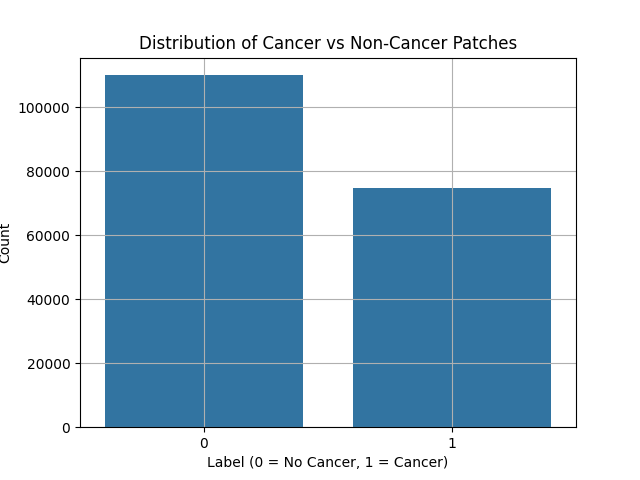

Picture below shows examples of different types of cells, with those labelled 0 as non-cancerous while those labelled 1 actually have cancer.

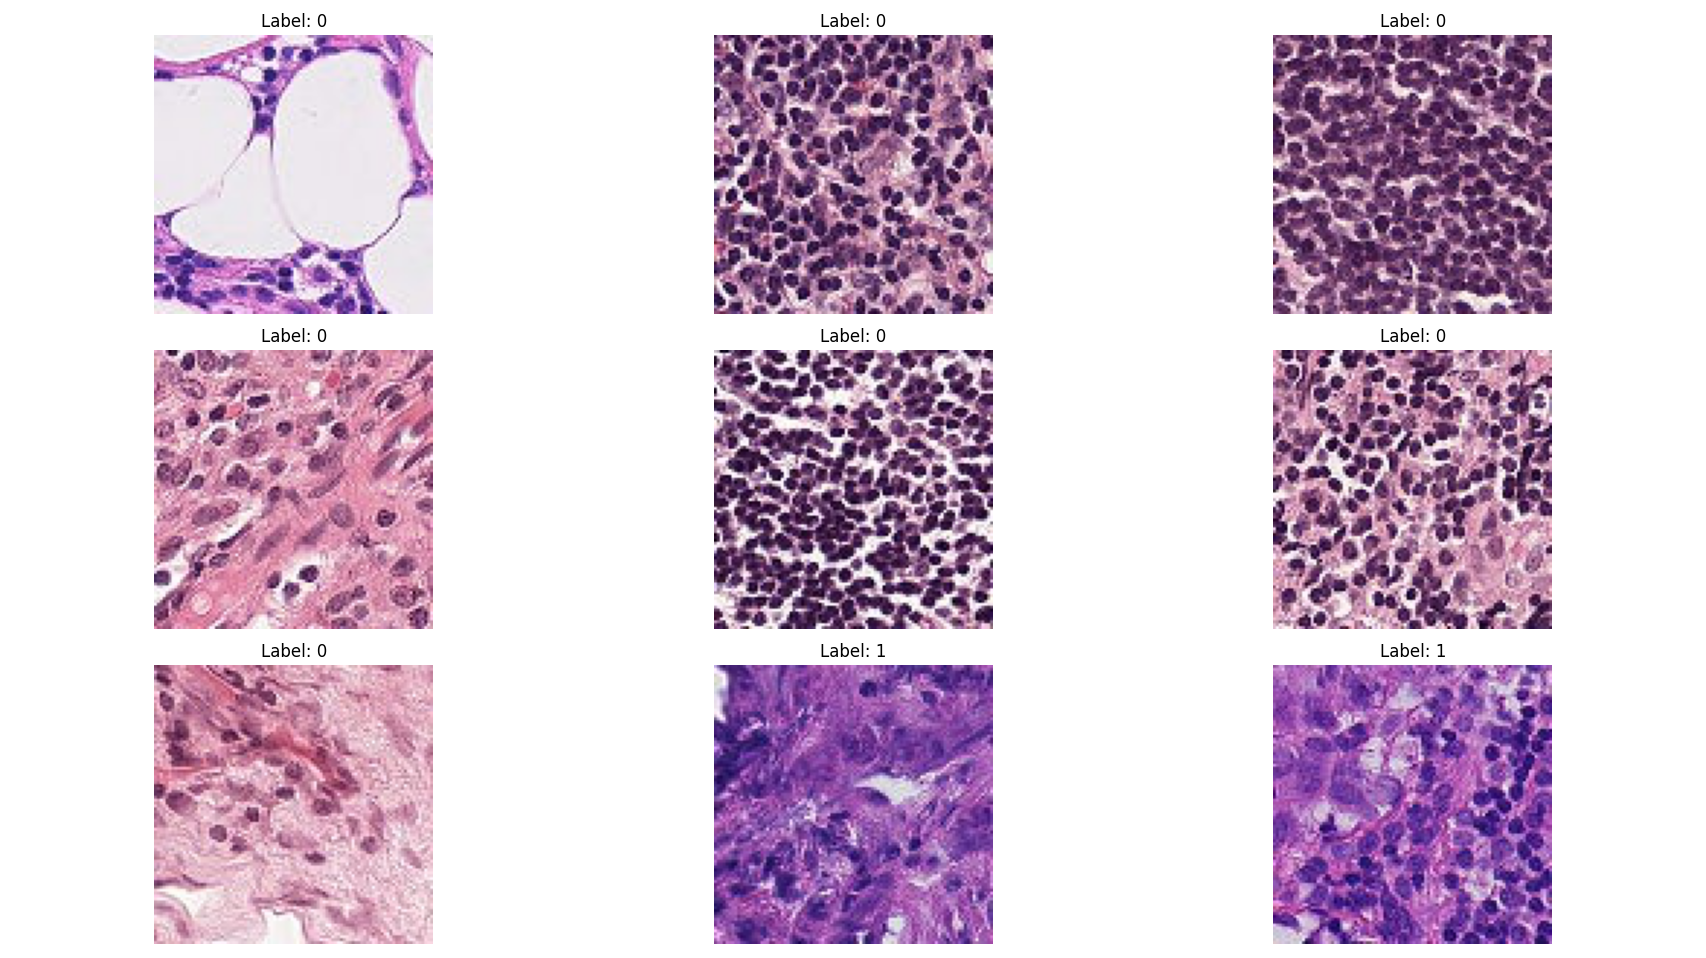

*The image below shows pixel density across all three channels. Red is more biased towards high intensity with green being more evenly distributed. Blue also reflects a bias towards intensity, albeit less so than red.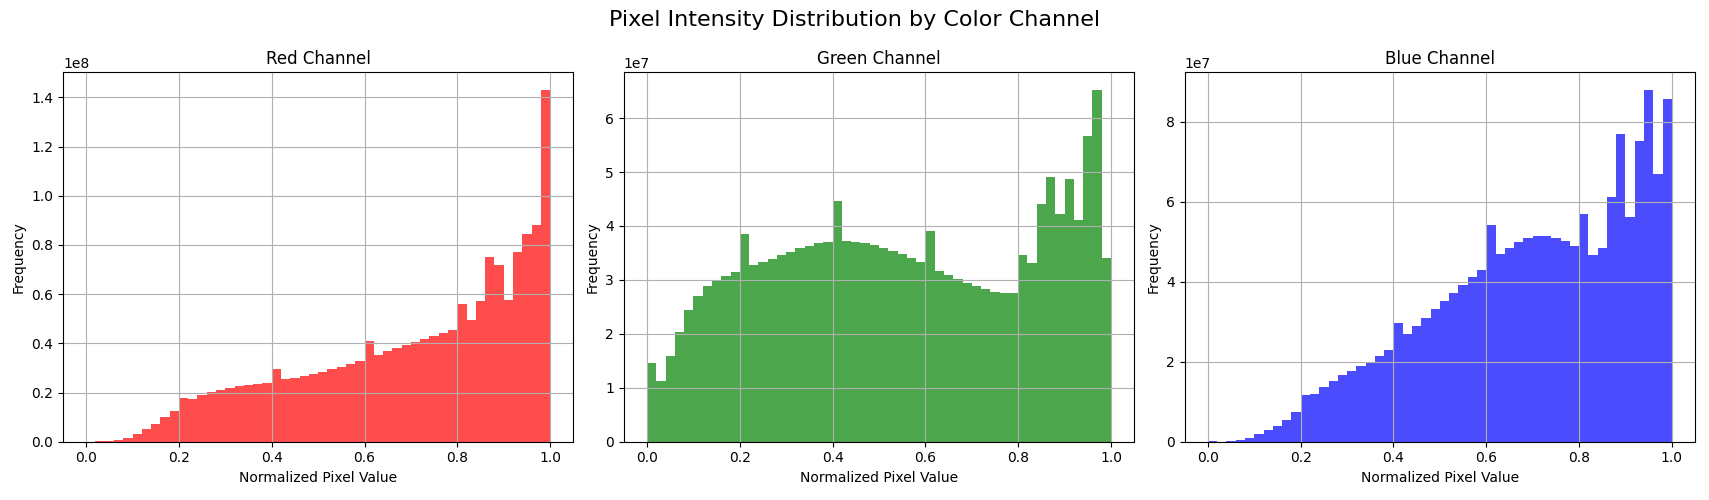*

In [ ]:
# cancer_eda.py

import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm

# Set up paths
base_path = r"C:\Users\apret\OneDrive\Desktop\histopathologic-cancer-detection"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
label_path = os.path.join(base_path, "train_labels.csv")

# Load and clean label data
df = pd.read_csv(label_path)
initial_len = len(df)

available_images = set(f[:-4] for f in os.listdir(train_path))
df = df[df['id'].isin(available_images)]

print(f"\nFiltered from {initial_len} → {len(df)} valid label entries.")
print(f"Number of test images in folder: {len(os.listdir(test_path))}")
print(df['label'].value_counts())

# Visualize class distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Cancer vs Non-Cancer Patches')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Show image samples
sample_ids = df.sample(9)['id'].values
plt.figure(figsize=(10, 10))
for i, img_id in enumerate(sample_ids):
    img = Image.open(os.path.join(train_path, f"{img_id}.tif"))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {df[df['id'] == img_id]['label'].values[0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Load and normalize images
all_images, all_labels = [], []
print("\nLoading and normalizing images...")
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
    img_path = os.path.join(train_path, f"{row['id']}.tif")
    with Image.open(img_path) as img:
        img_array = np.array(img).astype(np.float32) / 255.0
        all_images.append(img_array)
        all_labels.append(row['label'])

# Convert to arrays
X = np.array(all_images, dtype=np.float32)
y = np.array(all_labels, dtype=np.int64)

# Plot RGB channel histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
channels = ['Red', 'Green', 'Blue']
colors = ['red', 'green', 'blue']
for i in range(3):
    axs[i].hist(X[:, :, :, i].flatten(), bins=50, color=colors[i], alpha=0.7)
    axs[i].set_title(f"{channels[i]} Channel")
    axs[i].set_xlabel("Normalized Pixel Value")
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True)
fig.suptitle("Pixel Intensity Distribution by Color Channel", fontsize=16)
plt.tight_layout()
plt.show()

# Convert to tensors
X_tensor = torch.from_numpy(X).permute(0, 3, 1, 2)  # (N, 3, 96, 96)
y_tensor = torch.from_numpy(y)

print(f"Image tensor shape: {X_tensor.shape}")
print(f"Label tensor shape: {y_tensor.shape}")

print("Now it's.... saving time.... **shudders**")

# Save tensors
start = time.time()
torch.save(X_tensor, 'X_tensor.pt')
torch.save(y_tensor, 'y_tensor.pt')
print(f"Tensors saved in {time.time() - start:.2f} seconds")

# STEP 3: Model Architecture and Hyperparameter Tuning

In this step I tuned three different CNN's with varying depth and other hyperparameters to perform binary classification on potentially cancerous images. My goal was to obtain high accuracy with reasonable performance given my practical constraint of performing this analysis on my laptop.

All models share a common pattern: convolutional layers for feature extraction, ReLU activations for non-linearity, max pooling for spatial downsampling, and fully connected (linear) layers for final classification into two classes (tumor or no tumor).

###*Model A (Shallow CNN)*

*   1 convolutional layer: Conv2d(3, 16, kernel_size=3, padding=1)
*   Followed by MaxPool2d(2, 2) → reduces input from 96×96 to 48×48
*   Fully connected Linear(16×48×48, 64)
*   Fully connected Linear(64, 2)

This simple model serves as a baseline that can be trained and implemented fairly quickly, even on my current limited setup. That said, I expect it will be the least accurate.

###*Model B (Moderate CNN)*

*   Adds a second convolutional layer: Conv2d(32, 64, kernel_size=3, padding=1)
*   Two rounds of pooling reduce spatial dimensions to 24×24
*   The flattened representation (64×24×24) is passed through a denser layer: Linear(36864, 128)
*   Fully connected Linear(128, 2) at the end, still with only two final choices

This structure improves the model’s ability to learn more complex spatial features, but it comes at the cost of additional training time and complexity.

###*Model C (Deeper CNN with Regularization)*

*   Introduces a third convolutional layer: Conv2d(64, 128, kernel_size=3, padding=1)
*   Additional pooling reduces the size to 12×12
*   A deeper fully connected head: Linear(128×12×12, 256)
*   Dropout (p=0.5) added before final classification layer (256,2) to reduce overfitting

This model uses the highest capacity, but I expect it will be the most accurate as well as the most costly in terms of time and space.

#*Hyperparameters Used*
The following hyperparameters were used consistently across all three models:


*   Epochs: Only 5 epochs since we need to balance learning over time with available computational resources
*   Batch size: 64 (moderate size that fits in memory)
*   Optimizer: Adam (covered in class and handles noisy gradients)
*   Learning rate: 0.001 (small but large enough to permit movement)
*   Loss function: CrossEntropyLoss is standard for multi-classification
*   Non-linearity: ReLU is efficient and robust to vanishing gradients
*   Pooling: Max pooling reduces size and computations required
*   Kernel size and padding: 3 and 1 respectively (standard choices designed to maintain dimensions while capturing local features)

Given more robust resources, I would like to vary some of these features rather than keep as constants. I have held them constant here due to the difficulty in running multiple models on my current setup.

# STEP 4: Results and Analysis

This section evaluates the performance of the three CNN architectures described in Step 3. We looked a training loss over 5 epochs for each model, as well as its accuracy after these training epochs. Charts showing the accuracy and loss are provided below.

*   Model A, the shallowest network, converged quickly and reached ~80% accuracy with minimal training time. However, its limited capacity may miss subtle patterns in cancer-positive images.
*   Model B improved feature representation by adding a second convolutional layer, and results achieved a higher accuracy than Model A.
*   Model C added a third convolutional layer and dropout to prevent overfitting. While it takes longer to train, it is expected to generalize better due to both depth and regularization.

###*Loss Curves by Model*
A subplot was created to visualize the training loss across epochs for each model. These plots help illustrate a consistent downward trend in loss across all models with a lower final value for Model C, although the shallower models did seem to converge faster

###*Techniques to Improve Performance*

Several common techniques were incorporated:

*   Dropout in Model C improved robustness by reducing overfitting
*   ReLU activations ensured sparse, non-vanishing gradients
*   Adam optimizer provided smooth convergence with minimal tuning
*   Batch size (64) and learning rate (0.001) were chosen as reasonable defaults

###*Hyperparameter Tuning Summary*

Due to hardware constraints, formal grid/random hyperparameter search was not performed. Instead, a manual tuning approach was used with fixed values:

*   5 epochs
*   Learning rate of 0.001
*   Specific details as described in Step 3


###*Troubleshooting Notes*

I designed this using pkl files initially so that I could debug the models without re-running the preprocessing steps. This was extremely slow, so I switched to torch.save which was still slow but slightly less awful. I also made sure the dimensions for PyTorch were as expected (which is conveniently NOT what numpy provides).

#*STEP 5: Conclusion*
. Even without massive computing resources, however, the architecture and models were able to achieve meaningful performance.

I used three different CNN's to attempt a real world problem as part of a Kaggle competition. While larger models performed better, they were more difficult to use given the limited resources I had available. Despite these limitations, I was still able to get respectable results, but I am unable to fine tune them much beyond this. Increasing model performance must be balanced with training time, memory requirements, and overfitting risk, and I think my current three models are successful in balancing these requirements. Manually tuningand adding more layers with more filters did improve results, but it came at the cost of time and complexity.

###*Areas of Potential Improvement*
If more time or GPU access were available, I would explore:

*   Varying learning rates (e.g., 0.0001, 0.01)
*   Other optimizers (non-Adam)
*   More epochs with early stopping on validation loss
*   Data Augmentation



In [ ]:
# cancer_model.py

import torch
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load tensors using torch
print("Loading X_tensor.pt...")
X_tensor = torch.load("X_tensor.pt")

print("Loading y_tensor.pt...")
y_tensor = torch.load("y_tensor.pt")

# Prepare dataset and loaders
print("Preparing dataset and loaders...")
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Device setup
print("Handling device setup...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5

# Define models
print("Creating models a,b, and c")
model_a = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 48 * 48, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

model_b = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64 * 24 * 24, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

model_c = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128 * 12 * 12, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

print("Beginning the training exercise. Go grab a coffee for this one....")
models = [model_a, model_b, model_c]
model_names = ["Model A (Shallow)", "Model B (Moderate)", "Model C (Deep)"]
results = []

all_model_losses = []  # Store loss lists for each model


# Training loop
for model, name in zip(models, model_names):
    model_losses = []  # Track this model’s epoch losses
    print(f"\n Training {name}")
    start_time = time.time()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        model_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    all_model_losses.append(model_losses)

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    acc = 100 * correct / total
    print(f"{name} Accuracy: {acc:.2f}%")
    training_time = time.time() - start_time
    results.append({"Model": name, "Accuracy (%)": acc, "Training Time (s)": round(training_time, 1)})

# graph of loss per training epoch
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
model_names = ["Model A (Shallow)", "Model B (Moderate)", "Model C (Deep)"]

for i, (losses, name) in enumerate(zip(all_model_losses, model_names)):
    axs[i].plot(range(1, len(losses)+1), losses, marker='o')
    axs[i].set_title(name)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Loss")
    axs[i].set_xticks(range(1, len(losses)+1))
    axs[i].grid(True)

fig.suptitle("Training Loss per Epoch for Each Model", fontsize=16)
plt.tight_layout()
plt.show()

# Results DataFrame and plot
results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy (%)', data=results_df)
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

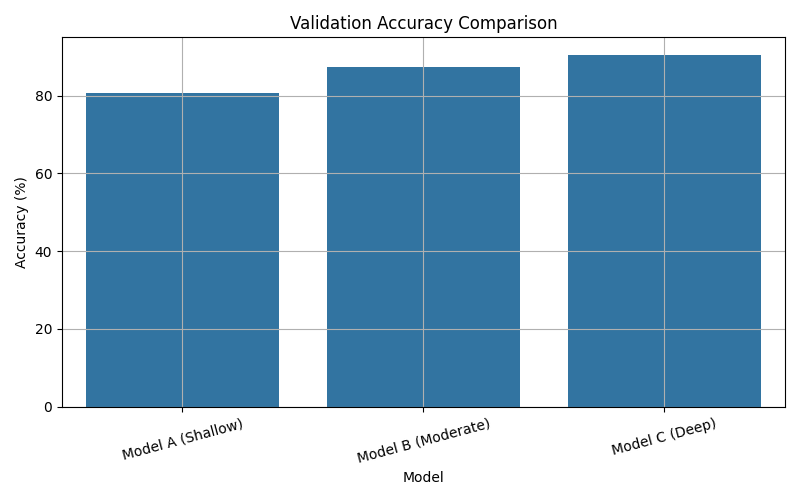

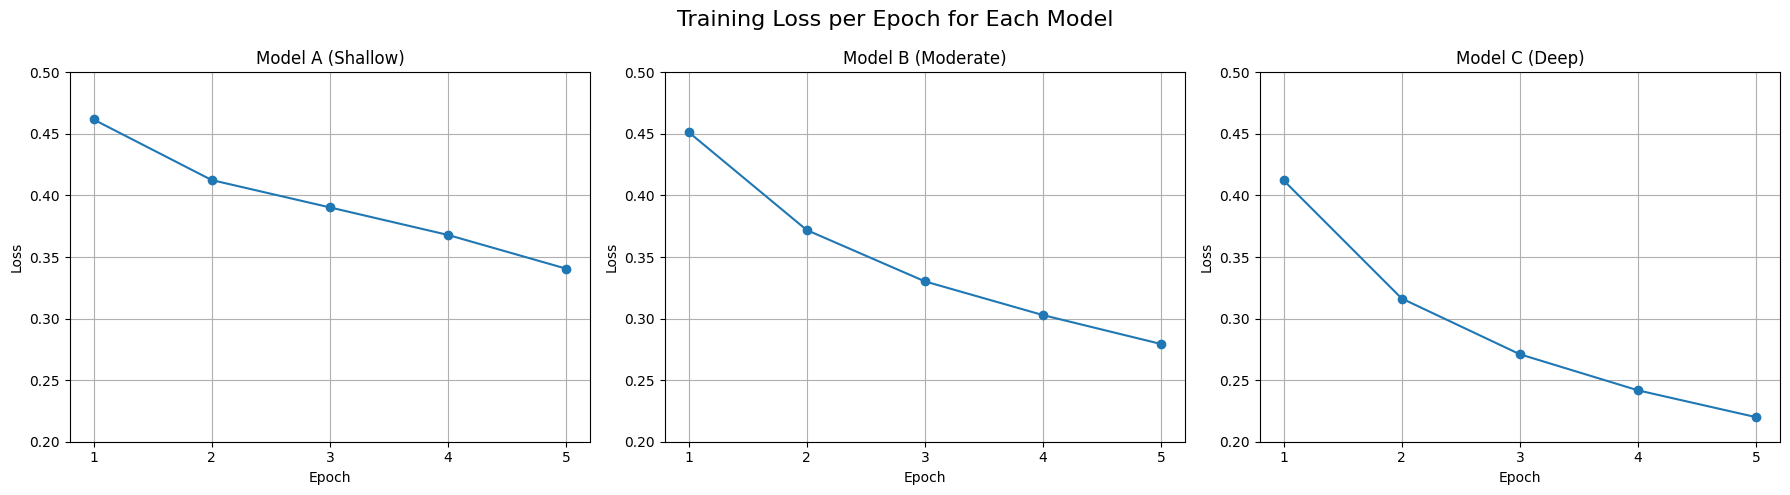

In [ ]:
print("Only use this code to manually generate the graph above if it is too slow to run properly.")

# import matplotlib.pyplot as plt

# # Manually entered epoch losses
# losses_a = [0.4617, 0.4125, 0.3903, 0.3679, 0.3405]
# losses_b = [0.4515, 0.3719, 0.3302, 0.3028, 0.2793]  # Add if known
# losses_c = [0.4123, 0.3163, 0.2710, 0.2417, 0.2199]  # Add if known

# model_losses = [losses_a, losses_b, losses_c]
# model_names = ['Model A (Shallow)', 'Model B (Moderate)', 'Model C (Deep)']

# fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# for i, (losses, name) in enumerate(zip(model_losses, model_names)):
#     axs[i].plot(range(1, len(losses)+1), losses, marker='o')
#     axs[i].set_title(name)
#     axs[i].set_xlabel("Epoch")
#     axs[i].set_ylabel("Loss")
#     axs[i].set_ylim(0.2, 0.5)
#     axs[i].set_xticks(range(1, len(losses)+1))
#     axs[i].grid(True)

# fig.suptitle("Training Loss per Epoch for Each Model", fontsize=16)
# plt.tight_layout()
# plt.show()


Only use this code to manually generate the graph above if it is too slow to run properly.
